<a href="https://colab.research.google.com/github/moter1026/review_Kinopoisk_lab5/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nlpaug


Импортирую необходимые библиотеки и получаю все отзывы из заранее созданного csv файла

In [68]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from typing import Tuple, Any
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import math
import random
import nlpaug.augmenter.word as npw

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from google.colab import drive
import sys

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')
sys.path.insert(0, "/content/drive/MyDrive/lab5_drive")
%cd /content/drive/MyDrive/lab5_drive/

allTextsDf = pd.read_csv("/content/drive/MyDrive/lab5_drive/big_description.csv")
print(allTextsDf)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/lab5_drive
                                           text of file class
0     Форрест Гамп\n\n\n\nФоррест Гамп – не совсем о...  good
1     Форрест Гамп\n\n\n\nСразу хочу сказать, что по...  good
2     Форрест Гамп\n\n\n\nКогда я сажусь смотреть ка...  good
3     Форрест Гамп\n\n\n\nВпервые посмотрев этот фил...  good
4     Форрест Гамп\n\n\n\nНе поспоришь - Том Хэнкс г...  good
...                                                 ...   ...
2123  Зеленая миля\n\n\n\nФильм не оправдал ожиданий...   bad
2124  Зеленая миля\n\n\n\nФактически фильм начинаетс...   bad
2125  Зеленая миля\n\n\n\n'Уж сколько раз твердили м...   bad
2126  Зеленая миля\n\n\n\nНе буду повторяться за пре...   bad
2127  Зеленая миля\n\n\n\nЧего ожидаешь, когда садиш...   bad

[2128 rows x 2 columns]


произвожу преобразование текста в нужный вид:

*   удаляю не буквенные символы
*   токенизирую (разбиваю текст на слова)
*   лемматизирую (привожу слова к базовой форме)
*   объединяю токены через пробел

In [69]:
def remove_non_alphabets(x) -> str:
  return re.sub(r'[^a-zA-Zа-яА-Я]', ' ', x)


In [70]:
tokenize = lambda x: word_tokenize(x, language="russian")

In [71]:
lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

In [72]:
def delete_stop_words(text_list: list) -> list:
  return [word for word in text_list if word.lower() not in stopwords.words('russian')]

In [73]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

print('Processing : [=', end='')
allTextsDf['text of file'] = allTextsDf['text of file'].apply(remove_non_alphabets)
print('=', end='')
allTextsDf['text of file'] = allTextsDf['text of file'].apply(tokenize) # [ word_tokenize(row) for row in data['text']]
print('=', end='')
allTextsDf['text of file'] = allTextsDf['text of file'].apply(leammtizer)
print('=', end='')
allTextsDf['text of file'] = allTextsDf['text of file'].apply(delete_stop_words)
print('=', end='')
allTextsDf['text of file'] = allTextsDf['text of file'].apply(lambda x: ' '.join(x))
print('] : Completed', end='')
allTextsDf.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Processing : [=====] : Completed

,text of file,class
0,Форрест Гамп Форрест Гамп обычный человек отст...,good
1,Форрест Гамп Сразу хочу сказать посмотрел филь...,good
2,Форрест Гамп сажусь смотреть расхваленный всем...,good
3,Форрест Гамп Впервые посмотрев фильм долго мог...,good
4,Форрест Гамп поспоришь Хэнкс гениален неважно ...,good


заменяю названия классов на числа

In [74]:
def change_labels(x: Any):
  # print(x)
  if x == 'good' or x == 1:
    return 1
  else:
    return 0
allTextsDf['class'] = allTextsDf['class'].apply(change_labels)
print(allTextsDf)

                                           text of file  class
0     Форрест Гамп Форрест Гамп обычный человек отст...      1
1     Форрест Гамп Сразу хочу сказать посмотрел филь...      1
2     Форрест Гамп сажусь смотреть расхваленный всем...      1
3     Форрест Гамп Впервые посмотрев фильм долго мог...      1
4     Форрест Гамп поспоришь Хэнкс гениален неважно ...      1
...                                                 ...    ...
2123  Зеленая миля Фильм оправдал ожиданий Сюжет абс...      0
2124  Зеленая миля Фактически фильм начинается момен...      0
2125  Зеленая миля сколько твердили миру лесть гнусн...      0
2126  Зеленая миля буду повторяться предыдущими крас...      0
2127  Зеленая миля ожидаешь садишься смотреть фильм ...      0

[2128 rows x 2 columns]


векторизация

In [246]:
max_words = 1000
cv = CountVectorizer(max_features=max_words)
sparse_matrix = cv.fit_transform(allTextsDf['text of file']).toarray()
sparse_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 4, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 1]])

In [247]:
sparse_matrix.shape

(2128, 1000)

In [248]:
x_train, x_temp, y_train, y_temp = train_test_split(sparse_matrix, np.array(allTextsDf['class']), test_size=0.2, random_state=42)

# Разделение временной выборки на тестовую и валидационную выборки
x_test, x_valid, y_test, y_valid = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [249]:
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()
x_valid = Variable(torch.from_numpy(x_valid)).float()
y_valid = Variable(torch.from_numpy(y_valid)).long()

In [250]:
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

In [251]:
x_train

tensor([[0., 2., 0.,  ..., 2., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Создаём класс для построения нейронной сети, где описываются все принципы, по которым будут данные будут перемещаться по ней

In [284]:
class TextNet(nn.Module):
  def __init__(self):
    super(TextNet, self).__init__()
    self.func1 = nn.Linear(1000, 800)
    self.func2 = nn.Linear(800, 100)
    self.func3 = nn.Linear(100, 10)
    self.func4 = nn.Linear(10, 2)

  def forward(self, x):
    x = F.relu(self.func1(x))
    x = F.relu(self.func2(x))
    x = F.relu(self.func3(x))
    x = self.func4(x)
    return x


создание экземпляра класса построения нейронки

In [253]:
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128]
epochs = 50
loss_values = []
models = []


Epoch 1/50, Training Loss: 0.6727, Training Accuracy: 0.4976, Validation Loss: 0.6037, Validation Accuracy: 0.5962
Epoch 2/50, Training Loss: 0.4464, Training Accuracy: 0.8660, Validation Loss: 0.3166, Validation Accuracy: 0.9437
Epoch 3/50, Training Loss: 0.2028, Training Accuracy: 0.9577, Validation Loss: 0.1755, Validation Accuracy: 0.9437
Epoch 4/50, Training Loss: 0.1104, Training Accuracy: 0.9747, Validation Loss: 0.1291, Validation Accuracy: 0.9531
Epoch 5/50, Training Loss: 0.0720, Training Accuracy: 0.9853, Validation Loss: 0.1143, Validation Accuracy: 0.9765
Epoch 6/50, Training Loss: 0.0500, Training Accuracy: 0.9918, Validation Loss: 0.0957, Validation Accuracy: 0.9671
Epoch 7/50, Training Loss: 0.0349, Training Accuracy: 0.9959, Validation Loss: 0.0873, Validation Accuracy: 0.9718
Epoch 8/50, Training Loss: 0.0264, Training Accuracy: 0.9976, Validation Loss: 0.0742, Validation Accuracy: 0.9718
Epoch 9/50, Training Loss: 0.0208, Training Accuracy: 0.9982, Validation Loss: 0

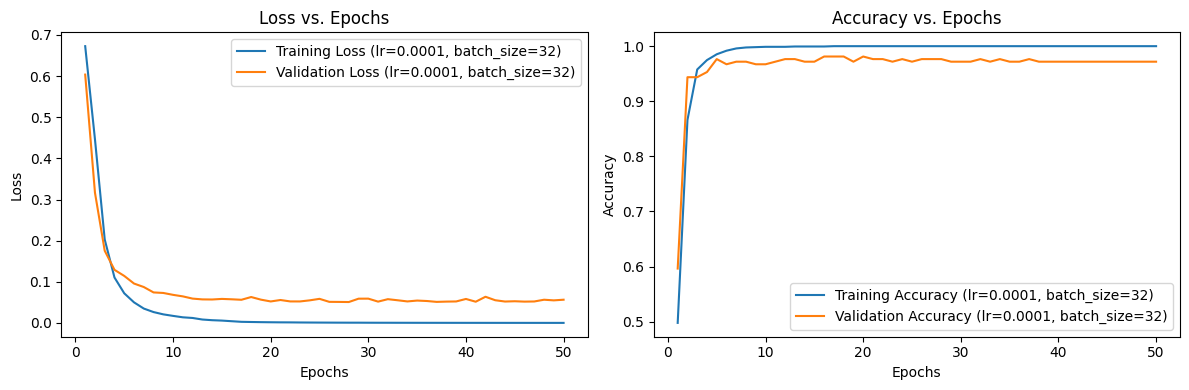

Epoch 1/50, Training Loss: 0.6802, Training Accuracy: 0.5276, Validation Loss: 0.6525, Validation Accuracy: 0.6526
Epoch 2/50, Training Loss: 0.5610, Training Accuracy: 0.8854, Validation Loss: 0.4951, Validation Accuracy: 0.9202
Epoch 3/50, Training Loss: 0.3730, Training Accuracy: 0.9489, Validation Loss: 0.3146, Validation Accuracy: 0.9437
Epoch 4/50, Training Loss: 0.2304, Training Accuracy: 0.9595, Validation Loss: 0.2016, Validation Accuracy: 0.9624
Epoch 5/50, Training Loss: 0.1518, Training Accuracy: 0.9700, Validation Loss: 0.1720, Validation Accuracy: 0.9671
Epoch 6/50, Training Loss: 0.1052, Training Accuracy: 0.9783, Validation Loss: 0.1176, Validation Accuracy: 0.9718
Epoch 7/50, Training Loss: 0.0766, Training Accuracy: 0.9853, Validation Loss: 0.1048, Validation Accuracy: 0.9718
Epoch 8/50, Training Loss: 0.0574, Training Accuracy: 0.9894, Validation Loss: 0.0949, Validation Accuracy: 0.9718
Epoch 9/50, Training Loss: 0.0432, Training Accuracy: 0.9941, Validation Loss: 0

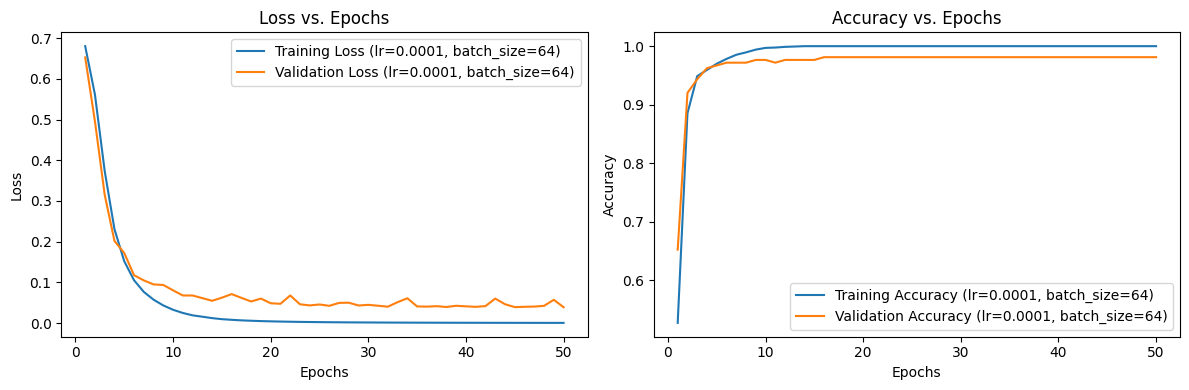

Epoch 1/50, Training Loss: 0.7018, Training Accuracy: 0.4747, Validation Loss: 0.6996, Validation Accuracy: 0.4554
Epoch 2/50, Training Loss: 0.6777, Training Accuracy: 0.4747, Validation Loss: 0.6688, Validation Accuracy: 0.4554
Epoch 3/50, Training Loss: 0.6315, Training Accuracy: 0.5170, Validation Loss: 0.6142, Validation Accuracy: 0.5258
Epoch 4/50, Training Loss: 0.5530, Training Accuracy: 0.6898, Validation Loss: 0.5262, Validation Accuracy: 0.7746
Epoch 5/50, Training Loss: 0.4525, Training Accuracy: 0.8884, Validation Loss: 0.4275, Validation Accuracy: 0.9202
Epoch 6/50, Training Loss: 0.3465, Training Accuracy: 0.9407, Validation Loss: 0.3257, Validation Accuracy: 0.9296
Epoch 7/50, Training Loss: 0.2552, Training Accuracy: 0.9606, Validation Loss: 0.2580, Validation Accuracy: 0.9390
Epoch 8/50, Training Loss: 0.1880, Training Accuracy: 0.9689, Validation Loss: 0.2054, Validation Accuracy: 0.9390
Epoch 9/50, Training Loss: 0.1389, Training Accuracy: 0.9747, Validation Loss: 0

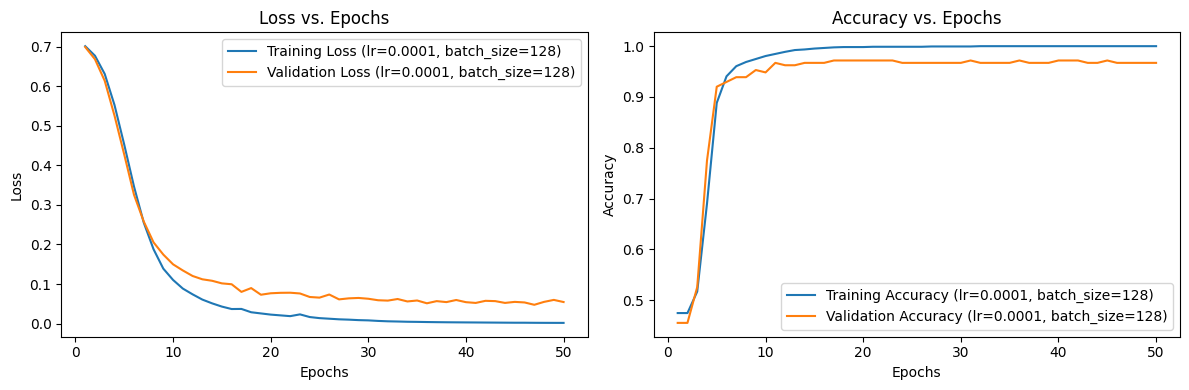

Epoch 1/50, Training Loss: 0.3925, Training Accuracy: 0.9007, Validation Loss: 0.1754, Validation Accuracy: 0.9765
Epoch 2/50, Training Loss: 0.1031, Training Accuracy: 0.9694, Validation Loss: 0.0732, Validation Accuracy: 0.9812
Epoch 3/50, Training Loss: 0.0345, Training Accuracy: 0.9906, Validation Loss: 0.0683, Validation Accuracy: 0.9718
Epoch 4/50, Training Loss: 0.0083, Training Accuracy: 0.9982, Validation Loss: 0.0657, Validation Accuracy: 0.9671
Epoch 5/50, Training Loss: 0.0019, Training Accuracy: 1.0000, Validation Loss: 0.0695, Validation Accuracy: 0.9765
Epoch 6/50, Training Loss: 0.0010, Training Accuracy: 1.0000, Validation Loss: 0.0721, Validation Accuracy: 0.9718
Epoch 7/50, Training Loss: 0.0006, Training Accuracy: 1.0000, Validation Loss: 0.0715, Validation Accuracy: 0.9765
Epoch 8/50, Training Loss: 0.0004, Training Accuracy: 1.0000, Validation Loss: 0.0862, Validation Accuracy: 0.9765
Epoch 9/50, Training Loss: 0.0003, Training Accuracy: 1.0000, Validation Loss: 0

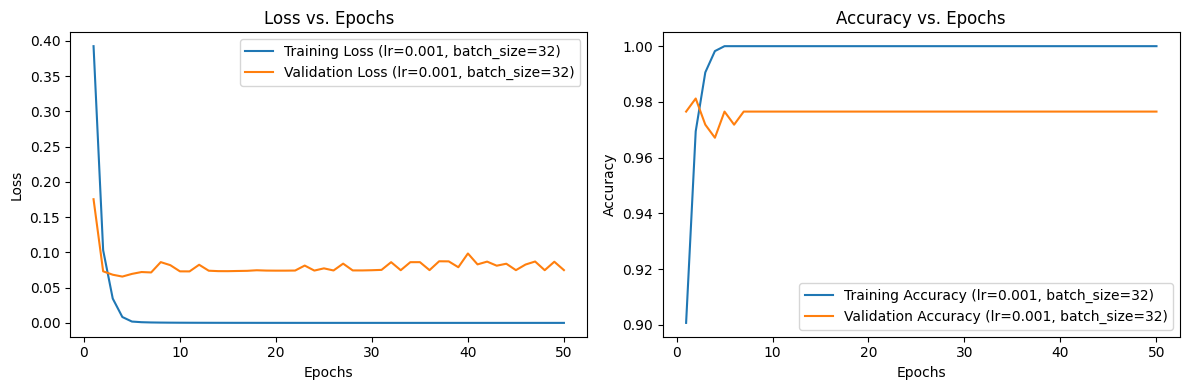

Epoch 1/50, Training Loss: 0.3548, Training Accuracy: 0.8860, Validation Loss: 0.1520, Validation Accuracy: 0.9390
Epoch 2/50, Training Loss: 0.0833, Training Accuracy: 0.9741, Validation Loss: 0.1170, Validation Accuracy: 0.9531
Epoch 3/50, Training Loss: 0.0289, Training Accuracy: 0.9953, Validation Loss: 0.1787, Validation Accuracy: 0.9484
Epoch 4/50, Training Loss: 0.0092, Training Accuracy: 0.9982, Validation Loss: 0.1025, Validation Accuracy: 0.9718
Epoch 5/50, Training Loss: 0.0024, Training Accuracy: 1.0000, Validation Loss: 0.0641, Validation Accuracy: 0.9765
Epoch 6/50, Training Loss: 0.0012, Training Accuracy: 1.0000, Validation Loss: 0.1115, Validation Accuracy: 0.9718
Epoch 7/50, Training Loss: 0.0008, Training Accuracy: 1.0000, Validation Loss: 0.0758, Validation Accuracy: 0.9718
Epoch 8/50, Training Loss: 0.0006, Training Accuracy: 1.0000, Validation Loss: 0.0546, Validation Accuracy: 0.9718
Epoch 9/50, Training Loss: 0.0004, Training Accuracy: 1.0000, Validation Loss: 0

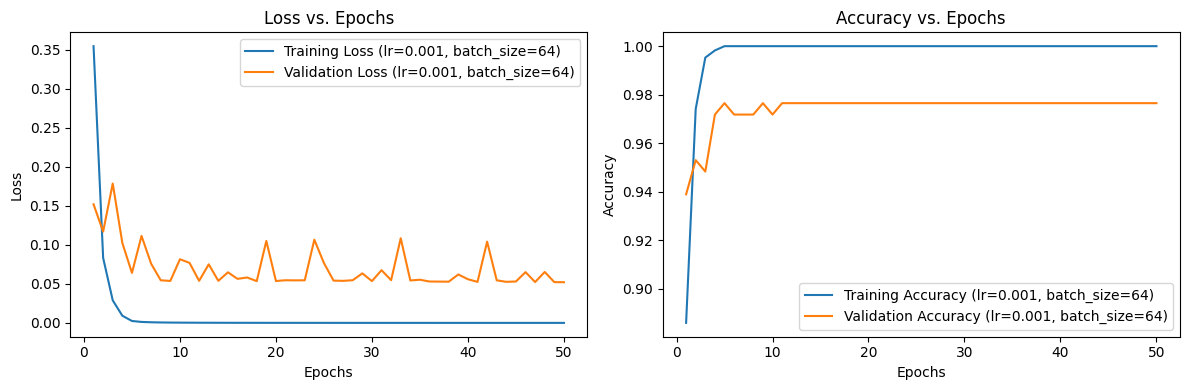

Epoch 1/50, Training Loss: 0.4376, Training Accuracy: 0.8331, Validation Loss: 0.1463, Validation Accuracy: 0.9577
Epoch 2/50, Training Loss: 0.1199, Training Accuracy: 0.9606, Validation Loss: 0.1427, Validation Accuracy: 0.9577
Epoch 3/50, Training Loss: 0.0533, Training Accuracy: 0.9800, Validation Loss: 0.0989, Validation Accuracy: 0.9718
Epoch 4/50, Training Loss: 0.0271, Training Accuracy: 0.9941, Validation Loss: 0.0692, Validation Accuracy: 0.9718
Epoch 5/50, Training Loss: 0.0114, Training Accuracy: 0.9971, Validation Loss: 0.0776, Validation Accuracy: 0.9718
Epoch 6/50, Training Loss: 0.0043, Training Accuracy: 1.0000, Validation Loss: 0.0752, Validation Accuracy: 0.9812
Epoch 7/50, Training Loss: 0.0022, Training Accuracy: 1.0000, Validation Loss: 0.0639, Validation Accuracy: 0.9765
Epoch 8/50, Training Loss: 0.0013, Training Accuracy: 1.0000, Validation Loss: 0.0701, Validation Accuracy: 0.9812
Epoch 9/50, Training Loss: 0.0008, Training Accuracy: 1.0000, Validation Loss: 0

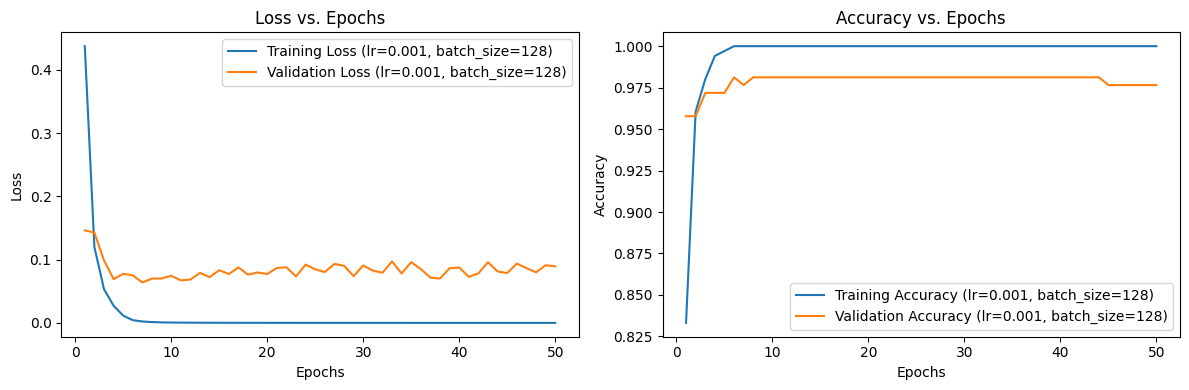

Epoch 1/50, Training Loss: 0.2368, Training Accuracy: 0.9107, Validation Loss: 0.1001, Validation Accuracy: 0.9671
Epoch 2/50, Training Loss: 0.1112, Training Accuracy: 0.9706, Validation Loss: 0.1314, Validation Accuracy: 0.9624
Epoch 3/50, Training Loss: 0.0507, Training Accuracy: 0.9818, Validation Loss: 0.1438, Validation Accuracy: 0.9577
Epoch 4/50, Training Loss: 0.0392, Training Accuracy: 0.9894, Validation Loss: 0.1923, Validation Accuracy: 0.9390
Epoch 5/50, Training Loss: 0.0355, Training Accuracy: 0.9847, Validation Loss: 0.3959, Validation Accuracy: 0.9108
Epoch 6/50, Training Loss: 0.0179, Training Accuracy: 0.9912, Validation Loss: 0.3324, Validation Accuracy: 0.9296
Epoch 7/50, Training Loss: 0.0223, Training Accuracy: 0.9941, Validation Loss: 0.1609, Validation Accuracy: 0.9249
Epoch 8/50, Training Loss: 0.0088, Training Accuracy: 0.9947, Validation Loss: 0.6835, Validation Accuracy: 0.9296
Epoch 9/50, Training Loss: 0.0158, Training Accuracy: 0.9947, Validation Loss: 0

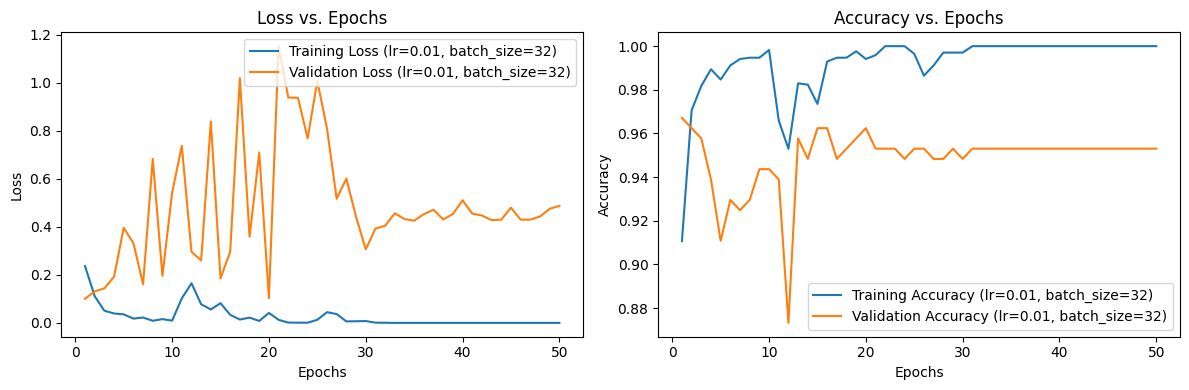

Epoch 1/50, Training Loss: 0.2500, Training Accuracy: 0.8772, Validation Loss: 0.1177, Validation Accuracy: 0.9624
Epoch 2/50, Training Loss: 0.0579, Training Accuracy: 0.9835, Validation Loss: 0.1192, Validation Accuracy: 0.9624
Epoch 3/50, Training Loss: 0.0279, Training Accuracy: 0.9906, Validation Loss: 0.1159, Validation Accuracy: 0.9484
Epoch 4/50, Training Loss: 0.0552, Training Accuracy: 0.9847, Validation Loss: 0.1618, Validation Accuracy: 0.9484
Epoch 5/50, Training Loss: 0.0118, Training Accuracy: 0.9965, Validation Loss: 0.1884, Validation Accuracy: 0.9624
Epoch 6/50, Training Loss: 0.0027, Training Accuracy: 0.9994, Validation Loss: 0.3031, Validation Accuracy: 0.9531
Epoch 7/50, Training Loss: 0.0383, Training Accuracy: 0.9900, Validation Loss: 0.2416, Validation Accuracy: 0.9437
Epoch 8/50, Training Loss: 0.0081, Training Accuracy: 0.9976, Validation Loss: 0.0518, Validation Accuracy: 0.9718
Epoch 9/50, Training Loss: 0.0014, Training Accuracy: 1.0000, Validation Loss: 0

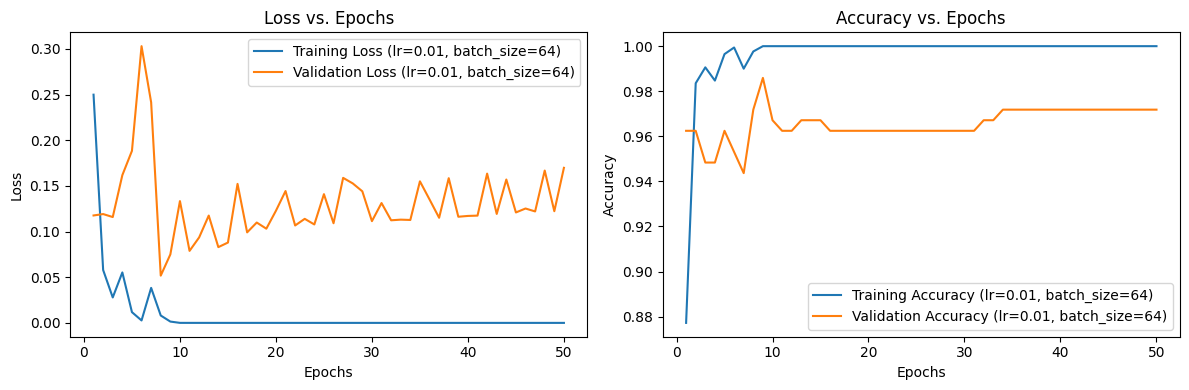

Epoch 1/50, Training Loss: 0.4128, Training Accuracy: 0.8508, Validation Loss: 0.1259, Validation Accuracy: 0.9531
Epoch 2/50, Training Loss: 0.0831, Training Accuracy: 0.9683, Validation Loss: 0.0831, Validation Accuracy: 0.9718
Epoch 3/50, Training Loss: 0.0249, Training Accuracy: 0.9924, Validation Loss: 0.1474, Validation Accuracy: 0.9671
Epoch 4/50, Training Loss: 0.0403, Training Accuracy: 0.9947, Validation Loss: 0.1684, Validation Accuracy: 0.9624
Epoch 5/50, Training Loss: 0.0163, Training Accuracy: 0.9947, Validation Loss: 0.1184, Validation Accuracy: 0.9624
Epoch 6/50, Training Loss: 0.0084, Training Accuracy: 0.9971, Validation Loss: 0.1803, Validation Accuracy: 0.9531
Epoch 7/50, Training Loss: 0.0028, Training Accuracy: 0.9994, Validation Loss: 0.2576, Validation Accuracy: 0.9484
Epoch 8/50, Training Loss: 0.0015, Training Accuracy: 0.9994, Validation Loss: 0.2968, Validation Accuracy: 0.9577
Epoch 9/50, Training Loss: 0.0005, Training Accuracy: 1.0000, Validation Loss: 0

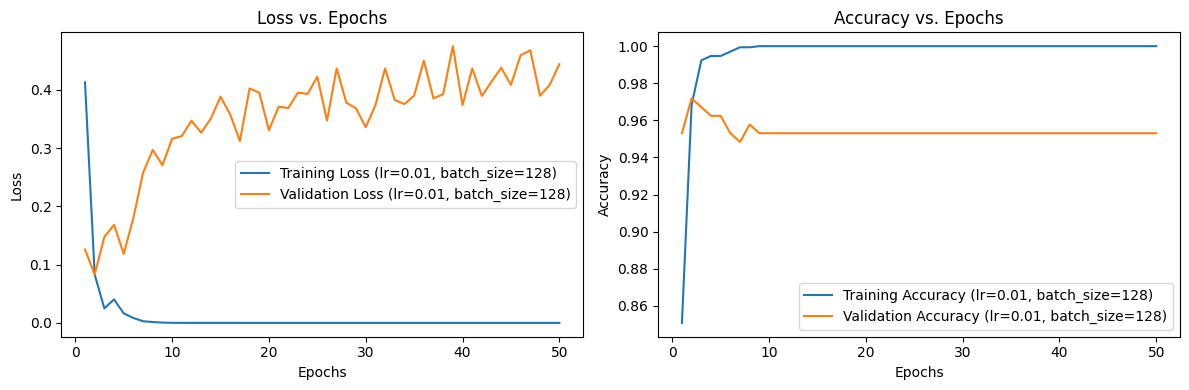

Test Accuracy: 0.9718


In [285]:
for lr in learning_rates:
    for batch_size in batch_sizes:
        model = TextNet()  # Create an instance of your model
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Training loop
        train_losses = []
        valid_losses = []
        train_accuracy = []
        valid_accuracy = []

        for epoch in range(epochs):
            model.train()

            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_losses.append(running_loss / len(train_loader))
            train_accuracy.append(correct_train / total_train)

            # Validation
            model.eval()

            running_loss = 0.0
            correct_valid = 0
            total_valid = 0

            with torch.no_grad():
                for inputs, labels in valid_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total_valid += labels.size(0)
                    correct_valid += (predicted == labels).sum().item()

                valid_losses.append(running_loss / len(valid_loader))
                valid_accuracy.append(correct_valid / total_valid)

                print(f'Epoch {epoch + 1}/{epochs}, '
                      f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, '
                      f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracy[-1]:.4f}')
                models.append(model)

        # Visualization
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_losses, label=f'Training Loss (lr={lr}, batch_size={batch_size})')
        plt.plot(range(1, epochs + 1), valid_losses, label=f'Validation Loss (lr={lr}, batch_size={batch_size})')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epochs')

        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_accuracy, label=f'Training Accuracy (lr={lr}, batch_size={batch_size})')
        plt.plot(range(1, epochs + 1), valid_accuracy, label=f'Validation Accuracy (lr={lr}, batch_size={batch_size})')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs. Epochs')

        plt.tight_layout()
        plt.show()

# Evaluate model on the test set
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

выбрав лучшие learning_rates и batch_size обучаю нейронную сеть для проверки работоспособности

In [286]:
batch_size = 64
lr = 0.0001
model = TextNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Training loop
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

epochs = 50

for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

            # Validation
    model.eval()

    running_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

        valid_losses.append(running_loss / len(valid_loader))
        valid_accuracy.append(correct_valid / total_valid)

In [287]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model.pth')

Оценка отзыва моделью

In [288]:
sample_review = """

Джедай, которого считают избранным - Энакин Скайуокер прошёл длинный путь от раба до мастера джедая. Он одолел множество противников и помог Республике в борьбе с сепаратистами. И вот он вновь помогает Республике, спасая канцлера Палпатина из лап врага. Канцлер настоял на том, чтобы Энакина сделали магистром, но совет джедаев это не одобрил, зато дал молодому джедаю место в совете в обмен на поручение следить за подозрительными действиями Палпатина. В это же время жена Энакина Падме забеременела, и ему начали приходить ведения о смерти любимой. Энакин помешался на идее спасения жены, а от подозрений к совету джедаев в измене Республике у избранного начинает ещё быстрее ехать крыша. Палпатину же дают всё больше полномочий на время действия войны.

Так себе история трилогии 'Звёздных войн', посвящённая жизни Оби-Вана Кеноби и его ученика, закончилась неожиданно потрясающе. 'Месть ситхов' я считаю лучшим фильмом по 'Звёздным войнам'. История развития Энакина является лучшей стороной сюжета предыдущих частей, а в 'Мести ситхов' почти весь фильм посвящён внутренним терзаниям, любовной драме и перевоплощению джедая. А остальное отведено очень неплохой политической драме и довольно интересным приключениям Оби-Вана.

По сравнению с предыдущими частями все персонажи кажутся куда более глубокими и сложными. Именно этот фильм делает Энакина Скайуокера самым интересным и 'сильным' персонажем 'Звёздных войн'. Оби-Ван, как всегда, на высоте. Падме уже не вызывает отторжения образом дамы в беде. Что касается второстепенных персонажей, они немного даже интересны благодаря колоритным образам. Для Палпатина это, кстати, тоже лучший фильм, как для персонажа.

Несмотря на всё вышеперечисленное, фильм не покинуло примитивное разграничение на плохих ситхов и хороших джедаев, поэтому полного погружения в политическую драму у меня не произошло и абстрагироваться от глупых условностей с тёмной и светлой стороной силы не получилось. Мотивация главного злодея также оставляет желать лучшего, однако гиперболизированные чувства персонажей пусть и не давали проникнуться их драмой на сто процентов, но зато погружали в шекспировскую трагедию, которая помогает создавать потрясающую атмосферу фильма.

Саундтрек 'Мести ситхов' включил в себя большую часть лучших композиций из всех 'Звёздных войн'. Дуэли на световых мечах в этой части являются общепризнанным эталоном подобных сцен. Эти сцены под божественный саундтрек самые красивые в жанре 'космических опер'. А личная драма Энакина, трагические политические события, печальная история Оби-Вана с плавным переходом в 'Новую надежду' добивают шкалу атмосферности фильма до максимума.

Безусловно, один из лучших фильмов, несмотря на неудачные предыдущие части.

"""

In [289]:
sample_review = remove_non_alphabets(sample_review)
sample_review = tokenize(sample_review)
sample_review = delete_stop_words(sample_review)
sample_review = leammtizer(sample_review)
sample_review = ' '.join(sample_review)


In [290]:
sample_review

'Джедай которого считают избранным Энакин Скайуокер прош л длинный путь раба мастера джедая одолел множество противников помог Республике борьбе сепаратистами вновь помогает Республике спасая канцлера Палпатина лап врага Канцлер настоял Энакина сделали магистром совет джедаев это одобрил зато дал молодому джедаю место совете обмен поручение следить подозрительными действиями Палпатина это время жена Энакина Падме забеременела начали приходить ведения смерти любимой Энакин помешался идее спасения жены подозрений совету джедаев измене Республике избранного начинает ещ быстрее ехать крыша Палпатину дают вс полномочий время действия войны история трилогии Зв здных войн посвящ нная жизни Оби Вана Кеноби ученика закончилась неожиданно потрясающе Месть ситхов считаю лучшим фильмом Зв здным войнам История развития Энакина является лучшей стороной сюжета предыдущих частей Мести ситхов весь фильм посвящ н внутренним терзаниям любовной драме перевоплощению джедая остальное отведено очень неплохой

In [291]:
max_words = 1000
cv = CountVectorizer(max_features=max_words)
sparse_matrix = cv.fit_transform(np.array([sample_review])).toarray()
if sparse_matrix.shape[1] < 1000:
    sparse_matrix = np.pad(sparse_matrix, ((0, 0), (0, 1000 - sparse_matrix.shape[1])))
sparse_matrix.shape

(1, 1000)

In [292]:
review = Variable(torch.from_numpy(sparse_matrix)).float()

загружаем предварительно обученную нейронку и состояние оптимизатора для модели из файла 'model.pth'

In [293]:
model = TextNet()
loaded_checkpoint = torch.load('model.pth')
model.load_state_dict(loaded_checkpoint['model_state_dict'])
optimizer.load_state_dict(loaded_checkpoint['optimizer_state_dict'])
epoch = loaded_checkpoint['epoch']

model.eval()

TextNet(
  (func1): Linear(in_features=1000, out_features=800, bias=True)
  (func2): Linear(in_features=800, out_features=100, bias=True)
  (func3): Linear(in_features=100, out_features=10, bias=True)
  (func4): Linear(in_features=10, out_features=2, bias=True)
)

In [294]:
with torch.no_grad():
    output = model(review)
    print('output: ', output)


predicted_class = torch.argmax(output).item()

print(f"Предсказанная оценка: {predicted_class}")

output:  tensor([[ 2.7993, -1.0349]])
Предсказанная оценка: 0
